In [43]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier  

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, f1_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


In [44]:
df = pd.read_csv('../Data/other_data/malicious_phish.csv')

In [45]:
df

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [ ]:
df['num_dots'] = df['url'].apply(lambda x: x.count('.'))
df['num_hyphens'] = df['url'].apply(lambda x: x.count('-'))
df['num_slashes'] = df['url'].apply(lambda x: x.count('/'))

def count_digits(url_string):
        if isinstance(url_string, str):
            return sum(c.isdigit() for c in url_string)
        return 0 
df['num_digits'] = df['url'].apply(count_digits)
df['num_equals'] = df['url'].apply(lambda x: x.count('=') if isinstance(x, str) else 0)

import re
from urllib.parse import urlparse

ip_pattern = re.compile(
    r"^(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}"
    r"(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$"
)

def has_ip_in_hostname(url_string):
    if not isinstance(url_string, str):
        return 0
    try:
        hostname = urlparse(url_string).hostname
        if hostname:
            if ip_pattern.fullmatch(hostname):  
                return 1 
    except Exception:  
        return 0
    return 0
df['ip_in_url'] = df['url'].apply(has_ip_in_hostname)


highly_suspicious_words = [ #  case-insensitive
    "secure", "account", "login", "signin", "banking", "confirm",
    "logon", "signon", "paypal", "payment", "ebay" , ".php", "abuse", "admin"
]

def check_for_highly_suspicious(url_string):
    if not isinstance(url_string, str): return 0
    url_lower = url_string.lower()
    for word in highly_suspicious_words:
        if word in url_lower: return 1
    for pattern in highly_suspicious_words:
        if pattern in url_string: return 1
    return 0

df['has_highly_susp_keyword'] = df['url'].apply(check_for_highly_suspicious)


def get_hostname_length(url):
    try:
        hostname = urlparse(url).hostname
        return len(hostname) if hostname else 0
    except:
        return 0
df['hostname_length'] = df['url'].apply(get_hostname_length)

additional_suspicious_words = [
    "webscr",           # PayPal-specific phishing
    "viewer.php",       # Suspicious PHP scripts
    "getImage.asp",     # Suspicious ASP scripts  
    "mail.php",         # Email-related PHP (often malicious)
    "link=",            # Redirect parameters
]
def has_additional_suspicious_words(url):
    url_lower = url.lower()
    return int(any(word.lower() in url_lower for word in additional_suspicious_words))

df['has_additional_susp_words'] = df['url'].apply(has_additional_suspicious_words)

def parse_url_components(url):
    try:
        parsed = urlparse(url)
        hostname = parsed.hostname if parsed.hostname else ''
        path = parsed.path if parsed.path else ''
        return hostname, path
    except:
        return '', ''

def has_susp_word_in_path(url, word_list):
    hostname, path = parse_url_components(url)
    for word in word_list:
        if word in path.lower(): 
            return 1
    return 0

def has_susp_word_in_hostname(url, word_list):
    hostname, path = parse_url_components(url)
    for word in word_list:
        if word in hostname.lower():  
            return 1
    return 0

highly_suspicious_words = [  
    "secure", "account", "login", "signin", "banking", "confirm",
    "logon", "signon", "paypal", "payment", "ebay" , ".php", "abuse", "admin"
]
all_susp_words = list(set(highly_suspicious_words + additional_suspicious_words))

df['has_susp_word_in_path'] = df['url'].apply(has_susp_word_in_path, args=(all_susp_words,))
df['has_susp_word_in_hostname'] = df['url'].apply(has_susp_word_in_hostname, args=(all_susp_words,))


In [ ]:
import tldextract

def get_tld(url_string):
    if not isinstance(url_string, str):
        return None  
    try:
        ext = tldextract.extract(url_string)
        return ext.suffix
    except Exception:
        return None 
    
if 'tld' not in df.columns:
    df['tld'] = df['url'].apply(get_tld)
    print("Added 'tld' column to DataFrame.")
else:
    print("'tld' column already exists.")


Added 'tld' column to DataFrame.


In [ ]:
def add_tld_features(df):
    df = df.copy()
    
    suspicious_tlds = ['tk', 'ml', 'ga', 'cf', 'cc', 'pw', 'top']
    df['has_suspicious_tld'] = df['tld'].isin(suspicious_tlds).astype(int)
    
    common_tlds = ['com', 'org', 'net', 'edu', 'gov']
    df['has_uncommon_tld'] = (~df['tld'].isin(common_tlds)).astype(int)
    
    return df

df = add_tld_features(df)

def calculate_entropy(text):
        try:
            if len(text) == 0:
                return 0
            char_counts = pd.Series(list(text.lower())).value_counts()
            probs = char_counts / len(text)
            entropy = -np.sum(probs * np.log2(probs))
            return entropy if not np.isnan(entropy) else 0
        except:
            return 0
    
df['url_entropy'] = df['url'].apply(calculate_entropy)
    
from urllib.parse import urlparse

MULTIPART_TLDS = {
    'co.uk', 'ac.uk', 'gov.uk',
    'com.au', 'net.au', 'org.au',
    'co.in', 'gov.in',
    'co.jp',
}

def count_subdomains(url_or_domain):
    try:
        if url_or_domain.startswith(('http://', 'https://')):
            domain = urlparse(url_or_domain).netloc
        else:
            domain = url_or_domain

        domain = domain.split(':')[0]
        parts = [p for p in domain.split('.') if p]

        if len(parts) <= 2:
            return 0

        tld = ".".join(parts[-2:])
        if tld in MULTIPART_TLDS and len(parts) > 2:
            return len(parts) - 3  
        else:
            return len(parts) - 2  

    except Exception:
        return 0

df['subdomain_count'] = df['url'].apply(count_subdomains)

def no_www(url):
    try:
        hostname = urlparse(url).netloc
        return 0 if hostname.startswith("www.") else 1
    except:
        return 1  
    
df['no_www'] = df['url'].apply(no_www)

df['tld_length'] = df['tld'].apply(lambda x: len(x) if isinstance(x, str) else -1)

import re

short_url_pattern = re.compile(
    r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
    r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
    r'short\.to|budurl\.com|ping\.fm|post\.ly|just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
    r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|lnkd\.in|'
    r'db\.tt|qr\.ae|adf\.ly|bitly\.com|cur\.lv|ow\.ly|ity\.im|q\.gs|po\.st|bc\.vc|twitthis\.com|'
    r'u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|prettylinkpro\.com|scrnch\.me|'
    r'filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|link\.zip\.net',
    re.IGNORECASE
)

def shortening_service(url):
    if short_url_pattern.search(url):
        return 1  
    else:
        return 0   

df['short_url'] = df['url'].apply(shortening_service)


def consonant_ratio(url):
    if not isinstance(url, str) or url.strip() == '':
        return 0  
    
    try:
        domain = urlparse(url).netloc.lower()
    except Exception:
        return 0  
    
    if domain.startswith('www.'):
        domain = domain[4:]
    
    vowels = "aeiou"
    letters = re.findall(r'[a-z]', domain)
    
    count_consonant_pairs = 0
    total_pairs = 0
    
    for i in range(len(letters) - 1):
        total_pairs += 1
        if letters[i] not in vowels and letters[i+1] not in vowels:
            count_consonant_pairs += 1
    
    if total_pairs == 0:
        return 0
    
    return count_consonant_pairs / total_pairs

df['consonant_pair_ratio'] = df['url'].apply(consonant_ratio)

import string

def punctuation_density(text):
    if not isinstance(text, str) or len(text) == 0:
        return 0
    punct_count = sum(1 for char in text if char in string.punctuation)
    return punct_count / len(text)

df['punctuation_density'] = df['url'].apply(punctuation_density)

def count_hex_encoding(url):
    return len(re.findall(r'%[0-9a-fA-F]{2}', url))

df['hex_encoding_count'] = df['url'].apply(count_hex_encoding)


def count_subdirectories(url):
    try:
        path = urlparse(url).path
        return len([p for p in path.split('/') if p])
    except:
        return 0

df['num_subdirs'] = df['url'].apply(count_subdirectories)
df['AtSymbol'] = df['url'].apply(lambda x: 1 if '@' in x else 0)
df['NumUnderscore'] = df['url'].apply(lambda x: x.count('_'))


def has_query_string(url):
    try:
        return 1 if '?' in urlparse(url).query else 0
    except:
        return 0

df['HasQueryString'] = df['url'].apply(has_query_string)

def get_path_length(url_string):
    if not isinstance(url_string, str): return 0
    try:
        path = urlparse(url_string).path
        return len(path)
    except: return 0

if 'path_length' not in df.columns:
    df['path_length'] = df['url'].apply(get_path_length)

def get_max_dir_length(url):
    try:
        path = urlparse(url).path
        directories = [d for d in path.split('/') if d]
        if not directories:
            return 0
        return max(len(d) for d in directories)
    except:
        return 0
    
df['max_dir_length'] = df['url'].apply(get_max_dir_length)



In [49]:

label_map = {
    'benign': 0,
    'phishing': 1,
    'defacement': 2
}

df['result'] = df['type'].map(label_map)


In [51]:
df = df.dropna(subset=['result'])


In [52]:
print(df['result'].value_counts())


result
0.0    428103
2.0     96457
1.0     94111
Name: count, dtype: int64


In [53]:
TARGET_COL = 'result'

feature_cols = [
    'num_dots',
    'num_hyphens', 
    'num_slashes',
    'num_digits',
    'num_equals',
    'ip_in_url',
    'has_highly_susp_keyword',
    'hostname_length',
    'has_additional_susp_words',
    'has_susp_word_in_path',
    'has_susp_word_in_hostname',
    'has_suspicious_tld',
    'has_uncommon_tld',
    'url_entropy',
    'subdomain_count',
    'no_www',
    'tld_length',
    'short_url',
    'consonant_pair_ratio',
    'punctuation_density',
    'hex_encoding_count',
    'num_subdirs',
    'AtSymbol',
    'NumUnderscore',
    'HasQueryString',
    # 'filename_length',

    'path_length',
    
    'max_dir_length',

    # 'hostname_uncommonness',
    # 'longest_dir_uncommonness'
]


In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df[feature_cols]
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Phishing', 'Defacement']))


              precision    recall  f1-score   support

      Benign       0.97      0.98      0.97     85621
    Phishing       0.90      0.83      0.86     18822
  Defacement       0.98      0.99      0.99     19292

    accuracy                           0.96    123735
   macro avg       0.95      0.94      0.94    123735
weighted avg       0.96      0.96      0.96    123735



Confusion Matrix (Random Forest):
[[83920  1695     6]
 [ 2832 15665   325]
 [   11    97 19184]]


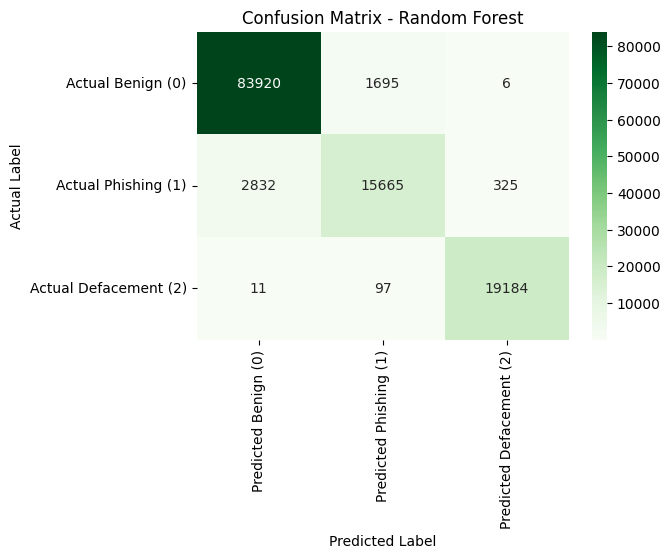

In [55]:
import seaborn as sns

print("Confusion Matrix (Random Forest):")
cm_rf = confusion_matrix(y_test, y_pred)
print(cm_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', # Changed cmap for distinction
            xticklabels=['Predicted Benign (0)', 'Predicted Phishing (1)' , 'Predicted Defacement (2)'],
            yticklabels=['Actual Benign (0)', 'Actual Phishing (1)', 'Actual Defacement (2)'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [57]:
new_csv = "../Data/other_data/otherdata-v1.csv"

try:
    df.to_csv(new_csv, index=False)
    print(f"DataFrame successfully saved to '{new_csv}'")
except Exception as e:
    print(f"Error saving DataFrame to CSV: {e}")


DataFrame successfully saved to '../Data/other_data/otherdata-v1.csv'


In [62]:
defacement_rows = df[df['type'] == 'defacement']
# print(defacement_rows)

new_csv = "../Data/other_data/defacement.csv"

defacement_rows.to_csv(new_csv, index=False)


In [59]:
df

,url,type,num_dots,num_hyphens,num_slashes,num_digits,num_equals,ip_in_url,has_highly_susp_keyword,hostname_length,...,consonant_pair_ratio,punctuation_density,hex_encoding_count,num_subdirs,AtSymbol,NumUnderscore,HasQueryString,path_length,max_dir_length,result
0,br-icloud.com.br,phishing,2,1,0,0,0,0,0,0,...,0.000000,0.187500,0,1,0,0,0,16,16,1.0
1,mp3raid.com/music/krizz_kaliko.html,benign,2,0,2,1,0,0,0,0,...,0.000000,0.142857,0,3,0,1,0,35,17,0.0
2,bopsecrets.org/rexroth/cr/1.htm,benign,2,0,3,1,0,0,0,0,...,0.000000,0.161290,0,4,0,0,0,31,14,0.0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,3,1,3,7,4,0,1,21,...,0.071429,0.204545,0,1,0,2,0,10,9,2.0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,2,1,3,22,3,0,1,23,...,0.100000,0.059574,0,1,0,1,0,10,9,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3,0,3,12,0,0,0,0,...,0.000000,0.153846,0,4,0,0,0,39,15,1.0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2,2,4,7,0,0,0,0,...,0.000000,0.181818,0,4,0,0,0,44,18,1.0
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,2,0,4,3,0,0,0,0,...,0.000000,0.142857,0,4,0,0,0,42,16,1.0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2,0,2,0,0,0,0,0,...,0.000000,0.200000,0,3,0,3,0,45,23,1.0


In [ ]:
new_csv = "../Data/processed/urldata-v2-noEquals.csv"

try:
    df.to_csv(new_csv, index=False)
    print(f"DataFrame successfully saved to '{new_csv}'")
except Exception as e:
    print(f"Error saving DataFrame to CSV: {e}")
